In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pathlib
import os
image_path = list(pathlib.Path('../input/butterfly-images40-species/butterflies').glob(r'**/*.jpg'))
image_label = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_path))

In [3]:
df = pd.DataFrame({"path":image_path,
                  "label":image_label})
df.head(5)

,path,label
0,../input/butterfly-images40-species/butterflie...,pipevine swallow
1,../input/butterfly-images40-species/butterflie...,pipevine swallow
2,../input/butterfly-images40-species/butterflie...,pipevine swallow
3,../input/butterfly-images40-species/butterflie...,pipevine swallow
4,../input/butterfly-images40-species/butterflie...,pipevine swallow


In [4]:
df["path"] = df["path"].astype(str)

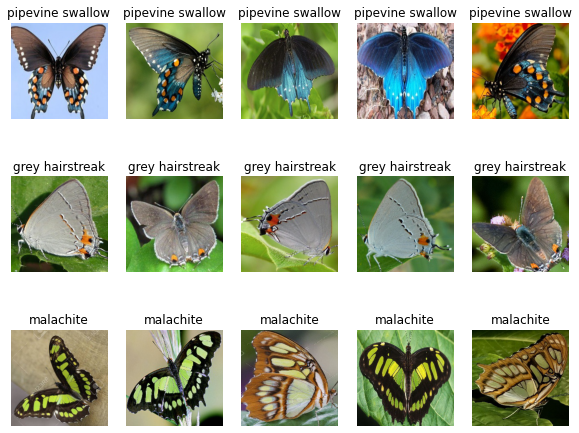

In [5]:
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize=(10, 8))

for i in range(15):
    row = df.loc[i]
    plt.subplot(3, 5, i+1)
    img = plt.imread(row.path)
    img = cv2.resize(img, (224, 224))
    plt.title(row.label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

In [6]:
df.shape

(5455, 2)

In [7]:
df.label[120]

'morning cloak'

In [8]:
df.label.value_counts()

scarce swallow         149
skipper                146
copper tail            144
sootywing              138
beckers white          126
indra swallow          125
julia                  125
purple hairstreak      123
painted lady           122
great eggfly           121
question mark          120
metalmark              118
zebra long wing        118
yellow swallow tail    117
american snoot         115
malachite              114
gold banded            114
crimson patch          113
wood satyr             112
sixspot burnet         111
orange oakleaf         110
grey hairstreak        108
peacock                107
eastern coma           106
straited queen         106
pine white             106
adonis                 106
red spotted purple     105
clouded sulphur        105
silver spot skipper    104
pipevine swallow       104
southern dogface       104
paper kite             102
cabbage white          102
an 88                  102
banded peacock         101
red admiral            101
b

In [9]:
class_names = df.label.unique()
class_names

array(['pipevine swallow', 'grey hairstreak', 'malachite',
       'cabbage white', 'copper tail', 'orange oakleaf', 'orange tip',
       'southern dogface', 'sixspot burnet', 'american snoot',
       'crimson patch', 'zebra long wing', 'great eggfly', 'gold banded',
       'purple hairstreak', 'question mark', 'julia', 'orchard swallow',
       'paper kite', 'sootywing', 'an 88', 'two barred flasher',
       'clodius parnassian', 'red admiral', 'morning cloak',
       'banded peacock', 'crecent', 'chestnut', 'indra swallow',
       'viceroy', 'pine white', 'adonis', 'silver spot skipper', 'ulyses',
       'black hairstreak', 'clouded sulphur', 'red spotted purple',
       'straited queen', 'monarch', 'wood satyr', 'eastern coma',
       'yellow swallow tail', 'beckers white', 'mangrove skipper',
       'skipper', 'peacock', 'painted lady', 'scarce swallow',
       'large marble', 'metalmark'], dtype=object)

In [10]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)

In [11]:
import tensorflow
train_data_gen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input,
                                                                validation_split=0.2)
test_data_gen = tensorflow.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet_v2.preprocess_input)

In [12]:
train_data = train_data_gen.flow_from_dataframe(dataframe=df_train,
                                               x_col = "path",
                                               y_col= "label",
                                               color_mode="rgb",
                                               class_mode="categorical",
                                               target_size=(224, 224),
                                               batch_size=32,
                                               shuffle=True,
                                               seed=42,
                                               subset="training")

Found 3928 validated image filenames belonging to 50 classes.


In [13]:
val_data = train_data_gen.flow_from_dataframe(dataframe=df_train,
                                             x_col="path",
                                             y_col="label",
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             target_size=(224, 224),
                                             batch_size=32,
                                             shuffle=True,
                                             seed=42,
                                             subset="validation")

Found 981 validated image filenames belonging to 50 classes.


In [14]:
test_data = test_data_gen.flow_from_dataframe(dataframe=df_test,
                                             x_col = "path",
                                             y_col = "label",
                                             color_mode = "rgb",
                                             class_mode = "categorical",
                                             target_size=(224, 224),
                                             batch_size=32,
                                             shuffle=False)

Found 546 validated image filenames belonging to 50 classes.


In [16]:
base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                              weights="imagenet",
                                              pooling="avg",
                                              include_top=False)
base_model.trainable=False

# Build model
inputs = tensorflow.keras.layers.Input(shape=(224, 224, 3))

x = base_model(inputs)
x = tensorflow.keras.layers.Dense(64, activation="relu")(x)
outputs = tensorflow.keras.layers.Dense(len(class_names), activation="softmax")(x)

model = tensorflow.keras.Model(inputs, outputs, name="mobilenet_v2_model")

# Compile
model.compile(loss="categorical_crossentropy",
             optimizer=tensorflow.keras.optimizers.Adam(),
             metrics=["accuracy"])

In [17]:
history = model.fit(train_data,
                    epochs=5,
                   validation_data = val_data,
                   callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                              patience=1,
                                                              restore_best_weights=True)])

2021-12-02 14:37:38.158943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
123/123 [==============================] - 74s 571ms/step - loss: 2.3093 - accuracy: 0.4705 - val_loss: 1.0904 - val_accuracy: 0.7431
Epoch 2/5
123/123 [==============================] - 63s 510ms/step - loss: 0.7120 - accuracy: 0.8297 - val_loss: 0.6367 - val_accuracy: 0.8287
Epoch 3/5
123/123 [==============================] - 63s 508ms/step - loss: 0.4258 - accuracy: 0.8900 - val_loss: 0.4803 - val_accuracy: 0.8777
Epoch 4/5
123/123 [==============================] - 63s 513ms/step - loss: 0.2893 - accuracy: 0.9315 - val_loss: 0.4153 - val_accuracy: 0.8940
Epoch 5/5
123/123 [==============================] - 63s 513ms/step - loss: 0.2107 - accuracy: 0.9570 - val_loss: 0.4025 - val_accuracy: 0.8828


In [18]:
model.evaluate(test_data)

18/18 [==============================] - 8s 425ms/step - loss: 0.4569 - accuracy: 0.8700


[0.4568854570388794, 0.8699633479118347]

In [19]:
pred_probs = model.predict(test_data)
preds = np.argmax(pred_probs, axis=1)

In [20]:
class_names = train_data.class_indices
class_names

{'adonis': 0,
 'american snoot': 1,
 'an 88': 2,
 'banded peacock': 3,
 'beckers white': 4,
 'black hairstreak': 5,
 'cabbage white': 6,
 'chestnut': 7,
 'clodius parnassian': 8,
 'clouded sulphur': 9,
 'copper tail': 10,
 'crecent': 11,
 'crimson patch': 12,
 'eastern coma': 13,
 'gold banded': 14,
 'great eggfly': 15,
 'grey hairstreak': 16,
 'indra swallow': 17,
 'julia': 18,
 'large marble': 19,
 'malachite': 20,
 'mangrove skipper': 21,
 'metalmark': 22,
 'monarch': 23,
 'morning cloak': 24,
 'orange oakleaf': 25,
 'orange tip': 26,
 'orchard swallow': 27,
 'painted lady': 28,
 'paper kite': 29,
 'peacock': 30,
 'pine white': 31,
 'pipevine swallow': 32,
 'purple hairstreak': 33,
 'question mark': 34,
 'red admiral': 35,
 'red spotted purple': 36,
 'scarce swallow': 37,
 'silver spot skipper': 38,
 'sixspot burnet': 39,
 'skipper': 40,
 'sootywing': 41,
 'southern dogface': 42,
 'straited queen': 43,
 'two barred flasher': 44,
 'ulyses': 45,
 'viceroy': 46,
 'wood satyr': 47,
 'ye

In [21]:
class_names = {y:x for x,y, in class_names.items()}
class_names

{0: 'adonis',
 1: 'american snoot',
 2: 'an 88',
 3: 'banded peacock',
 4: 'beckers white',
 5: 'black hairstreak',
 6: 'cabbage white',
 7: 'chestnut',
 8: 'clodius parnassian',
 9: 'clouded sulphur',
 10: 'copper tail',
 11: 'crecent',
 12: 'crimson patch',
 13: 'eastern coma',
 14: 'gold banded',
 15: 'great eggfly',
 16: 'grey hairstreak',
 17: 'indra swallow',
 18: 'julia',
 19: 'large marble',
 20: 'malachite',
 21: 'mangrove skipper',
 22: 'metalmark',
 23: 'monarch',
 24: 'morning cloak',
 25: 'orange oakleaf',
 26: 'orange tip',
 27: 'orchard swallow',
 28: 'painted lady',
 29: 'paper kite',
 30: 'peacock',
 31: 'pine white',
 32: 'pipevine swallow',
 33: 'purple hairstreak',
 34: 'question mark',
 35: 'red admiral',
 36: 'red spotted purple',
 37: 'scarce swallow',
 38: 'silver spot skipper',
 39: 'sixspot burnet',
 40: 'skipper',
 41: 'sootywing',
 42: 'southern dogface',
 43: 'straited queen',
 44: 'two barred flasher',
 45: 'ulyses',
 46: 'viceroy',
 47: 'wood satyr',
 48:

In [22]:
pred_names = [class_names[i] for i in preds]
y_true = list(df_test.label)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred_names))

                     precision    recall  f1-score   support

             adonis       0.92      0.85      0.88        13
     american snoot       0.79      1.00      0.88        11
              an 88       1.00      1.00      1.00        10
     banded peacock       1.00      0.92      0.96        12
      beckers white       0.89      0.80      0.84        10
   black hairstreak       0.85      1.00      0.92        11
      cabbage white       1.00      1.00      1.00         9
           chestnut       1.00      1.00      1.00        10
 clodius parnassian       1.00      1.00      1.00         3
    clouded sulphur       0.60      0.90      0.72        10
        copper tail       0.69      0.92      0.79        12
            crecent       1.00      0.33      0.50         3
      crimson patch       1.00      1.00      1.00        11
       eastern coma       0.82      0.75      0.78        12
        gold banded       0.81      0.93      0.87        14
       great eggfly    